In [2]:
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import h5py
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.patches import Rectangle


In [3]:
path = Path("/media/jam/HDD/dmi/radar/2025/dk_202509091530.h5")

In [106]:
with h5py.File(path, "r") as f:
    # List top-level keys
    print("Top-level groups/datasets:", list(f.keys()))

    def walk(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(
                f"DATASET: {name} shape={obj.shape} dtype={obj.dtype} attrs={list(obj.attrs.keys())}"
            )
        elif isinstance(obj, h5py.Group):
            print(f"GROUP:   {name} attrs={list(obj.attrs.keys())}")

    f.visititems(walk)

Top-level groups/datasets: ['dataset1', 'how', 'what', 'where']
GROUP:   dataset1 attrs=[]
GROUP:   dataset1/data1 attrs=['quantity']
DATASET: dataset1/data1/data shape=(1728, 1984) dtype=uint8 attrs=['CLASS', 'IMAGE_VERSION']
GROUP:   how attrs=['zr-a', 'zr-b']
GROUP:   what attrs=['date', 'gain', 'nodata', 'object', 'offset', 'product', 'source', 'time', 'undetect', 'version']
GROUP:   where attrs=['LL_lat', 'LL_lon', 'LR_lat', 'LR_lon', 'UL_lat', 'UL_lon', 'UR_lat', 'UR_lon', 'projdef', 'xscale', 'yscale']


In [107]:
with h5py.File(path, "r") as f:
    dset = f["dataset1"]["data1"]["data"]
    arr = dset[...]
    xr_da = xr.DataArray(
        arr,
        dims=("lat", "lon"),  # adjust as needed
        attrs=dict(dset.attrs),
    )
    where = f["where"]
    print(where)

<HDF5 group "/where" (0 members)>


In [99]:
# where

In [122]:
xr_da.min()

<xarray.DataArray ()> Size: 1B
array(0, dtype=uint8)

In [119]:
xr_da.to_dataset(name="radar")

<xarray.Dataset> Size: 3MB
Dimensions:  (lat: 1728, lon: 1984)
Dimensions without coordinates: lat, lon
Data variables:
    radar    (lat, lon) uint8 3MB 255 255 255 255 255 ... 255 255 255 255 255

In [ ]:
with h5py.File(path, "r") as f:
    data = f["dataset1"]["data1"]["data"][...]  # (ny, nx) uint8
    quantity = f["dataset1"]["data1"].attrs.get("quantity", b"var")
    if isinstance(quantity, bytes):
        quantity = quantity.decode()

    what = f["what"].attrs
    where = f["where"].attrs

    # Decode bytes -> python types
    def _val(a):
        return a.decode() if isinstance(a, (bytes, bytearray)) else a

    date_str = _val(what["date"])  # 'YYYYMMDD'
    time_str = _val(what["time"])  # 'HHMMSS'
    ts = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")

    gain = float(what.get("gain", 1.0))
    offset = float(what.get("offset", 0.0))
    nodata = what.get("nodata", None)
    undetect = what.get("undetect", None)

    # Scale data
    scaled = data.astype("float32") * gain + offset

    # Mask
    mask = np.zeros_like(scaled, dtype=bool)
    if nodata is not None:
        mask |= data == nodata
    if undetect is not None:
        mask |= data == undetect
    scaled = np.ma.masked_array(scaled, mask=mask)

    ny, nx = data.shape

    # Corner coordinates
    UL_lat, UL_lon = float(where["UL_lat"]), float(where["UL_lon"])
    UR_lat, UR_lon = float(where["UR_lat"]), float(where["UR_lon"])
    LL_lat, LL_lon = float(where["LL_lat"]), float(where["LL_lon"])
    LR_lat, LR_lon = float(where["LR_lat"]), float(where["LR_lon"])

    # Bilinear interpolation of lat/lon over the pixel grid
    wx = np.linspace(0.0, 1.0, nx)  # left->right
    wy = np.linspace(0.0, 1.0, ny)  # top->bottom

    top_lat = UL_lat + wx * (UR_lat - UL_lat)
    top_lon = UL_lon + wx * (UR_lon - UL_lon)
    bottom_lat = LL_lat + wx * (LR_lat - LL_lat)
    bottom_lon = LL_lon + wx * (LR_lon - LL_lon)

    lat2d = (top_lat * (1 - wy[:, None])) + (bottom_lat * wy[:, None])
    lon2d = (top_lon * (1 - wy[:, None])) + (bottom_lon * wy[:, None])

    da = xr.DataArray(
        scaled[np.newaxis, ...],  # add time dim
        dims=("time", "y", "x"),
        coords=dict(
            time=[np.datetime64(ts)],
            lat=(("y", "x"), lat2d),
            lon=(("y", "x"), lon2d),
        ),
        name=quantity,
        attrs={
            "gain": gain,
            "offset": offset,
            "nodata": nodata,
            "undetect": undetect,
            "projection": _val(where.get("projdef", "")),
            "description": quantity,
            "source": _val(what.get("source", "")),
            "product": _val(what.get("product", "")),
        },
    )

da

/tmp/ipykernel_3143/2332498029.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UL_lat, UL_lon = float(where["UL_lat"]), float(where["UL_lon"])
/tmp/ipykernel_3143/2332498029.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UR_lat, UR_lon = float(where["UR_lat"]), float(where["UR_lon"])
/tmp/ipykernel_3143/2332498029.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  LL_lat, LL_lon = float(where["LL_lat"]), float(where["LL_lon"])
/tmp/ipykernel_3143/23324

<xarray.DataArray 'DBZH' (time: 1, y: 1728, x: 1984)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 1728, 1984), dtype=float32)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 27MB 60.0 60.0 60.0 60.0 ... 52.29 52.29 52.29 52.29
    lon      (y, x) float64 27MB 3.0 3.009 3.018 3.027 ... 18.88 18.89 18.89
Dimensions without coordinates: y, x
Attributes:
    gain:         0.5
    offset:       -32.0
    nodata:       255
    undetect:     0.0
    projection:   +proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56
    description:  DBZH
    source:       DMI-RADARGROUP
    product:      DBZH

In [ ]:
da.to_dataset()

<xarray.Dataset> Size: 69MB
Dimensions:  (time: 1, y: 1728, x: 1984)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 27MB 60.0 60.0 60.0 60.0 ... 52.29 52.29 52.29 52.29
    lon      (y, x) float64 27MB 3.0 3.009 3.018 3.027 ... 18.88 18.89 18.89
Dimensions without coordinates: y, x
Data variables:
    DBZH     (time, y, x) float32 14MB nan nan nan nan nan ... nan nan nan nan

In [123]:
print(da)

<xarray.DataArray 'DBZH' (time: 1, y: 1728, x: 1984)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 1728, 1984), dtype=float32)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 27MB 60.0 60.0 60.0 60.0 ... 52.29 52.29 52.29 52.29
    lon      (y, x) float64 27MB 3.0 3.009 3.018 3.027 ... 18.88 18.89 18.89
Dimensions without coordinates: y, x
Attributes:
    gain:         0.5
    offset:       -32.0
    nodata:       255
    undetect:     0.0
    projection:   +proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56
    description:  DBZH
    source:       DMI-RADARGROUP
    product:      DBZH


In [129]:
# For your rectangle case (9.4-10.4°E, 56.4-57.4°N)
def select_region(da, lat_range, lon_range):
    """Select a geographic region from 2D coordinate data"""
    lat_min, lat_max = lat_range
    lon_min, lon_max = lon_range

    # Create mask
    mask = (
        (da.lat >= lat_min)
        & (da.lat <= lat_max)
        & (da.lon >= lon_min)
        & (da.lon <= lon_max)
    )

    # Find bounding box
    y_idx, x_idx = np.where(mask)

    if len(y_idx) == 0:
        return None

    # Get min/max indices with some padding
    y_slice = slice(max(0, y_idx.min() - 1), min(da.sizes["y"], y_idx.max() + 2))
    x_slice = slice(max(0, x_idx.min() - 1), min(da.sizes["x"], x_idx.max() + 2))

    return da.isel(y=y_slice, x=x_slice)


# Use the function
da_subset = select_region(da.to_dataset(), (56.4, 57.4), (9.4, 10.4))

In [130]:
da_subset

<xarray.Dataset> Size: 575kB
Dimensions:  (time: 1, y: 230, x: 125)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 230kB 57.41 57.41 57.41 57.41 ... 56.39 56.39 56.39
    lon      (y, x) float64 230kB 9.366 9.374 9.383 9.391 ... 10.4 10.4 10.41
Dimensions without coordinates: y, x
Data variables:
    DBZH     (time, y, x) float32 115kB nan nan nan nan nan ... nan nan nan nan

In [111]:
lat2d.shape

(1728, 1984)

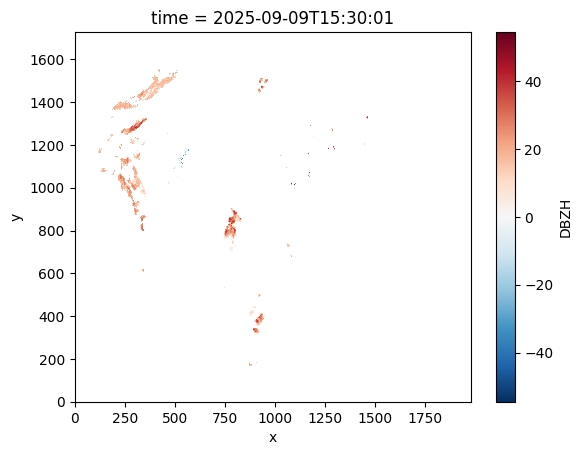

In [ ]:
# da.plot()

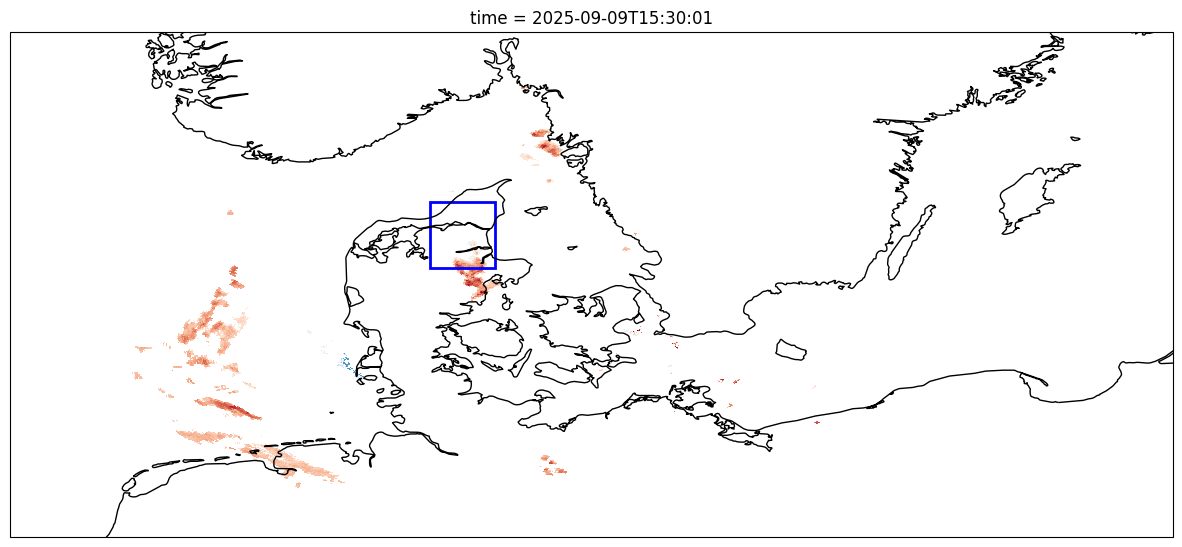

In [ ]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 10))
ax1 = plt.axes(projection=proj)
da.isel(time=0).plot.pcolormesh(
    ax=ax1,
    transform=proj,
    x="lon",
    y="lat",
    add_colorbar=False,
)

rect1 = Rectangle((9.4, 56.4), 1, 1, color="blue", fc="none", lw=2)

ax1.add_patch(rect1)

ax1.coastlines()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [ ]:
da

<xarray.DataArray 'DBZH' (time: 1, y: 1728, x: 1984)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(1, 1728, 1984), dtype=float32)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 27MB 60.0 60.0 60.0 60.0 ... 52.29 52.29 52.29 52.29
    lon      (y, x) float64 27MB 3.0 3.009 3.018 3.027 ... 18.88 18.89 18.89
Dimensions without coordinates: y, x
Attributes:
    gain:         0.5
    offset:       -32.0
    nodata:       255
    undetect:     0.0
    projection:   +proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56
    description:  DBZH
    source:       DMI-RADARGROUP
    product:      DBZH

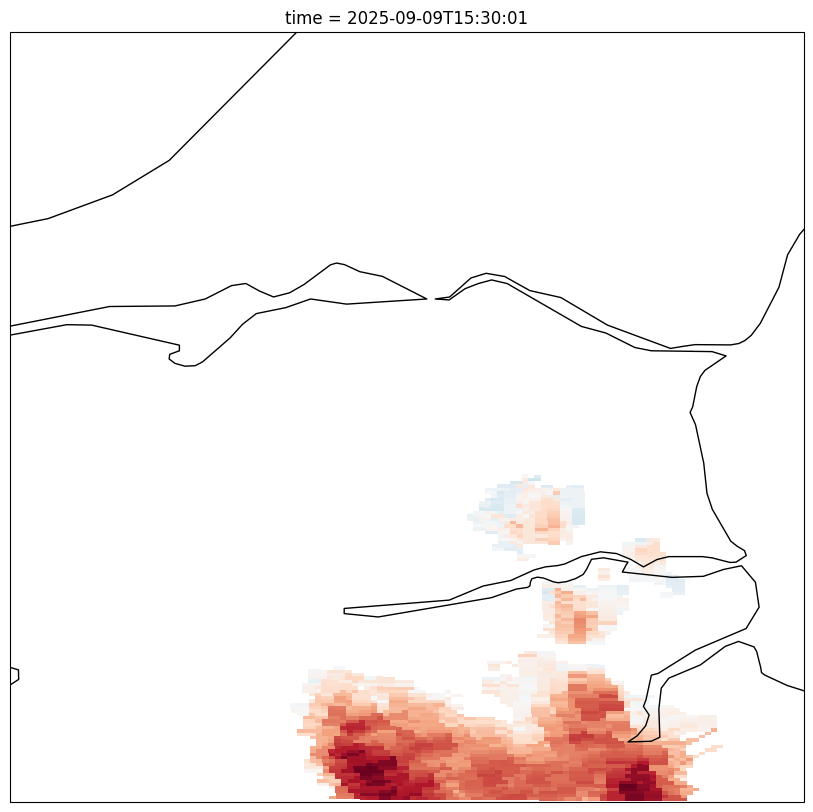

In [127]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 10))
ax1 = plt.axes(projection=proj)
da_subset.isel(time=0).plot.pcolormesh(
    ax=ax1,
    transform=proj,
    x="lon",
    y="lat",
    add_colorbar=False,
)

# rect1 = Rectangle((9.4, 56.4), 1, 1, color="blue", fc="none", lw=2)

# ax1.add_patch(rect1)

ax1.coastlines()

plt.gcf().set_size_inches(15, 10)
plt.show()

In [4]:
from radar_forcast.data import open_h5, select_region

da = open_h5(path=path)

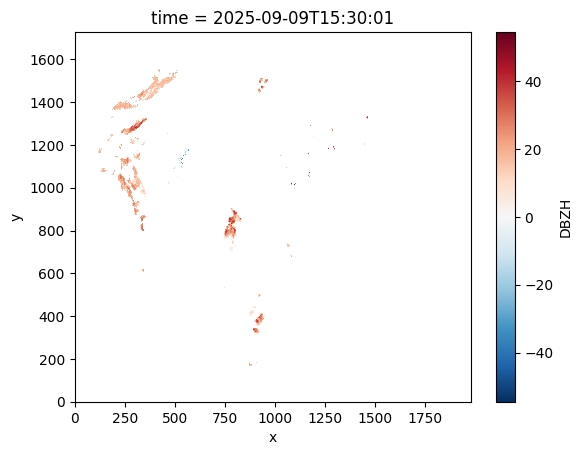

In [5]:
da.plot()

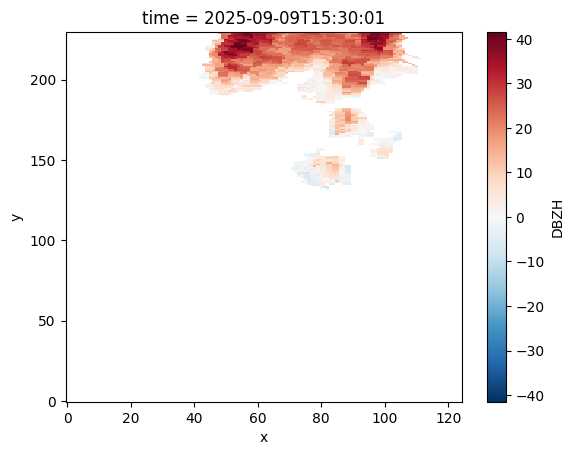

In [6]:
sub = select_region(da, (56.4, 57.4), (9.4, 10.4))
sub.plot()

In [8]:
sub.to_dataset()

<xarray.Dataset> Size: 575kB
Dimensions:  (time: 1, y: 230, x: 125)
Coordinates:
  * time     (time) datetime64[us] 8B 2025-09-09T15:30:01
    lat      (y, x) float64 230kB 57.41 57.41 57.41 57.41 ... 56.39 56.39 56.39
    lon      (y, x) float64 230kB 9.366 9.374 9.383 9.391 ... 10.4 10.4 10.41
Dimensions without coordinates: y, x
Data variables:
    DBZH     (time, y, x) float32 115kB nan nan nan nan nan ... nan nan nan nan

In [4]:
import pandas as pd

pd.Timestamp(2025, 1, 1, 12, 0, 0).year

2025